# GEONE - DEESSE - Simulations with geometrical transformations

## Main points addressed

- deesse simulation with rotation and/or scaling: local or global / with or without tolerance (uncertainty)

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


## 1. Global transformation - fixed values (without tolerance)

### Training image (TI)

In [3]:
# Read file 
data_dir = 'data'
filename = os.path.join(data_dir, 'ti.txt')
ti = gn.img.readImageTxt(filename)

# Values in the TI
ti.get_unique()

array([0., 1., 2.])

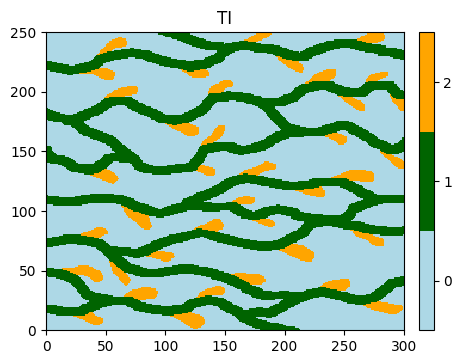

In [4]:
# Setting for categories / colors
categ_val = [0, 1, 2]
categ_col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categVal=categ_val, categCol=categ_col, title='TI')
plt.show()

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [5]:
nx, ny, nz = 400, 300, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Fill the input structure for deesse and launch deesse
Specify homothety (scaling) and rotation.

**Note:** in presence of both transformations the structures obtained in output are the structures of the TI that have been *rescaled* first and then *rotated*.

In [6]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    homothetyUsage=1,           # use homothety (scaling) without tolerance
    homothetyXLocal=False,      #    along x: global homothety
    homothetyXRatio=1.33,       #    along x: value for scaling factor
    homothetyYLocal=False,      #    along y: global homothety
    homothetyYRatio=0.75,       #    along y: value for scaling factor
    rotationUsage=1,            # use rotation without tolerance
    rotationAzimuthLocal=False, #    rotation according to azimuth: global
    rotationAzimuth=20.,        #    rotation azimuth: value
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 2 sec


### Retrieve the results (and display)

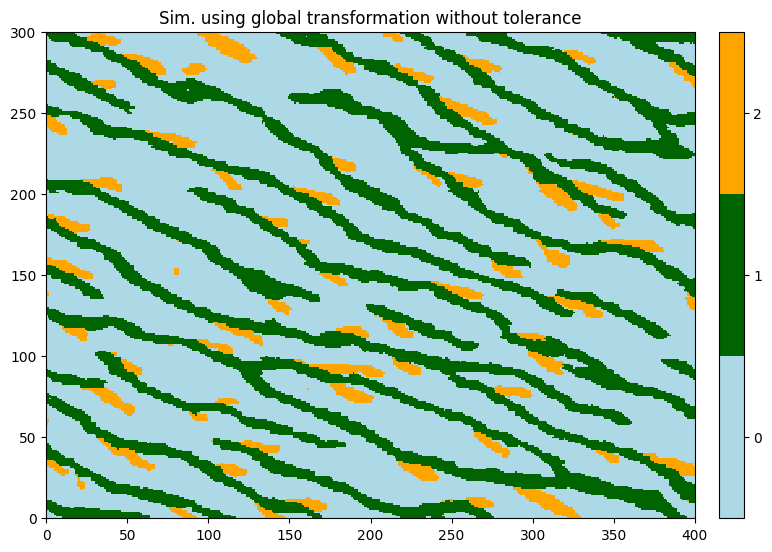

In [7]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col,
                       title='Sim. using global transformation without tolerance')
plt.show()

## 2. Global transformations - with tolerance

One can specify a range of value for the geometrical transformations.

In [8]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    homothetyUsage=2,           # use homothety (scaling) with tolerance
    homothetyXLocal=False,      #    along x: global homothety
    homothetyXRatio=[0.5, 2.],  #    along x: min and max values for scaling factor
    homothetyYLocal=False,      #    along y: global homothety
    homothetyYRatio=[0.5, 2.],  #    along y: min and max values for scaling factor
    rotationUsage=2,            # use rotation with tolerance
    rotationAzimuthLocal=False, #    rotation according to azimuth: global
    rotationAzimuth=[0., 180.], #    rotation azimuth: min and max values
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 3.3 sec


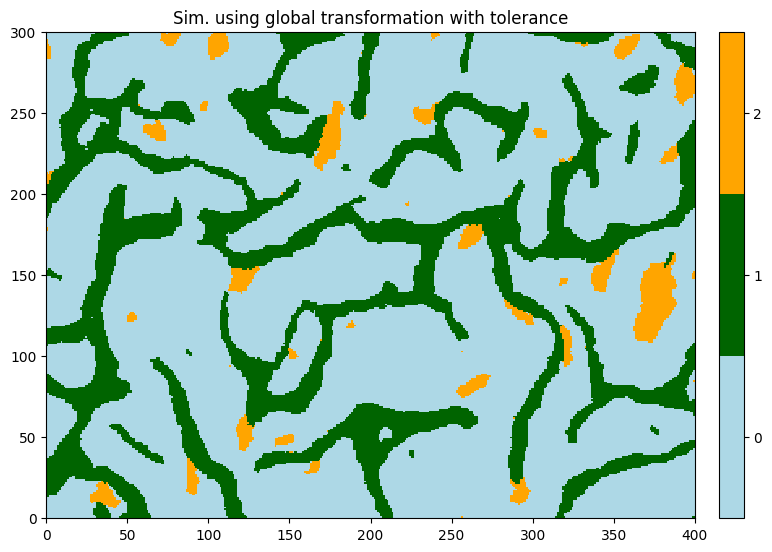

In [9]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col,
                       title='Sim. using global transformation with tolerance')
plt.show()

## 3. Local transformations - fixed values (without tolerance)

### Build a map for homothety ratio and azimuth angle

Below, a piece of python code to build:

- `scaling`: (`nz`, `ny`, `nx`)-array containing homothety ratio values on the simulation grid
- `angle`: (`nz`, `ny`, `nx`)-array containing angle values on the simulation grid

In [10]:
# Set an image with simulation grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()[0]
yy = im.yy()[0]

# Equivalent:
## xg, yg: coordinates of the centers of grid cell
#xg = ox + 0.5*sx + sx*np.arange(nx)
#yg = oy + 0.5*sy + sy*np.arange(ny)
#xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Set some parameters to build the variables scaling and angle
center_x, center_y = 250, 150
scaling_start, scaling_end = 1., 0.5

# Set scaling values over the grid
scaling = np.sqrt((xx-center_x)**2 + (yy-center_y)**2)
scaling_min = np.min(scaling)
scaling_max = np.max(scaling)
scaling = scaling_start + (scaling - scaling_min)/(scaling_max - scaling_min) * (scaling_end - scaling_start)

# Set angle values over the grid
angle = -np.arctan2(yy-center_y, xx-center_x)*180./np.pi

# Reshape (not necessary)
scaling = scaling.reshape(nz, ny, nx)
angle = angle.reshape(nz, ny, nx)

### Display homothety ratio map and azimuth map

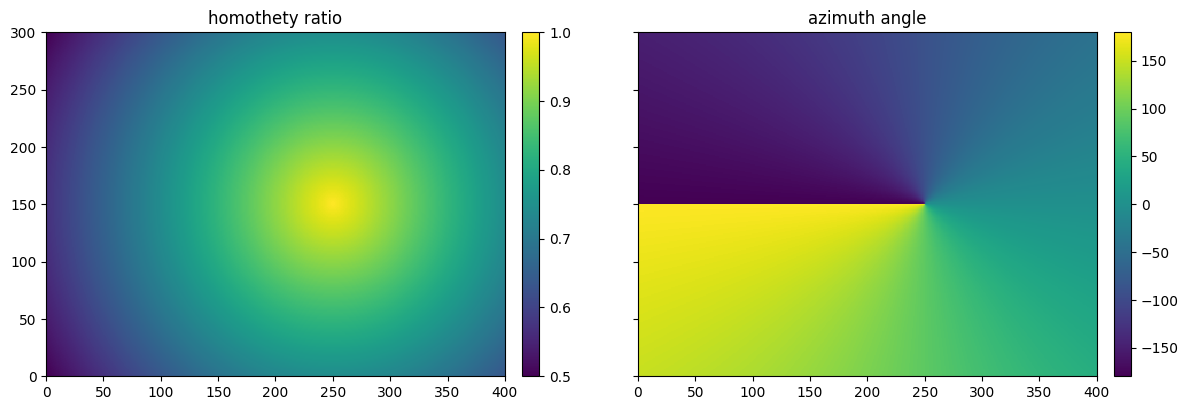

In [11]:
# Set variable scaling and angle in image im
im.append_var([scaling, angle], varname=['scaling', 'angle'])

# Display
plt.subplots(1,2, figsize=(14,7), sharey=True) # 1 x 2 sub-plots

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im, iv=0, title='homothety ratio')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im, iv=1, title='azimuth angle')

plt.show()

### Fill the input structure for deesse and launch deesse

In [12]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    homothetyUsage=1,           # use homothety (scaling) without tolerance
    homothetyXLocal=True,       #    along x: local homothety
    homothetyXRatio=scaling,    #    along x: map of values for scaling factor
    homothetyYLocal=True,       #    along y: local homothety
    homothetyYRatio=scaling,    #    along y: map of values for scaling factor
    rotationUsage=1,            # use rotation without tolerance
    rotationAzimuthLocal=True,  #    rotation according to azimuth: local
    rotationAzimuth=angle,      #    rotation azimuth: map of values
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 2.5 sec


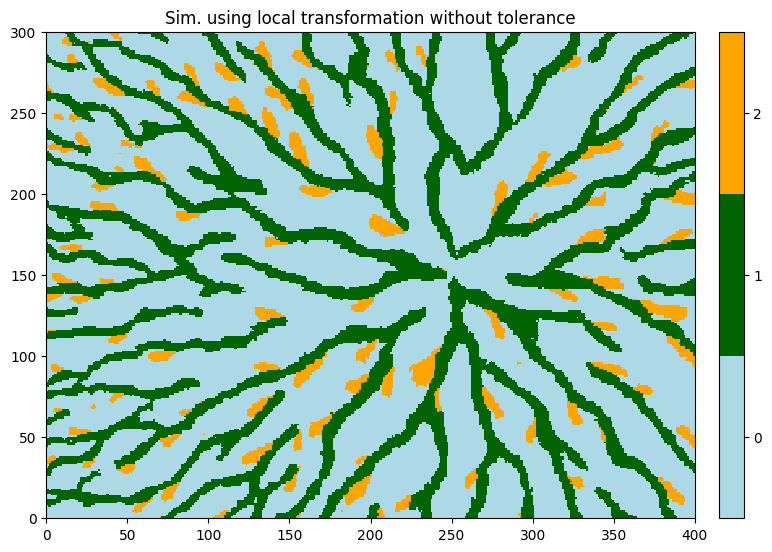

In [13]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col,
                       title='Sim. using local transformation without tolerance')
plt.show()

## 4. Local transformations - with tolerance

The minimal and maximal values (range) for the considered transformation must be given at each cell of the simulation grid:

- `scaling_min_max`: (2, `nz`, `ny`, `nx`)-array containing homothety min and max ratio values on the simulation grid
- `angle_min_max`: (2, `nz`, `ny`, `nx`)-array containing min and max angle values on the simulation grid

In [14]:
scaling_tol = 0.3
scaling_min_max = np.array((scaling-scaling_tol, scaling+scaling_tol))

angle_tol = 45.
angle_min_max = np.array((angle-angle_tol, angle+angle_tol))

deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    TI=ti,
    homothetyUsage=2,                # use homothety (scaling) with tolerance
    homothetyXLocal=True,            #    along x: local homothety
    homothetyXRatio=scaling_min_max, #    along x: map of min and max values for scaling factor
    homothetyYLocal=True,            #    along y: local homothety
    homothetyYRatio=scaling_min_max, #    along y: map of min and max values for scaling factor
    rotationUsage=2,                 # use rotation with tolerance
    rotationAzimuthLocal=True,       #    rotation according to azimuth: local
    rotationAzimuth=angle_min_max,   #    rotation azimuth: map of min and max values
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseRun: DeeSse running... [VERSION 3.2 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseRun: DeeSse run complete
Elapsed time: 4.9 sec


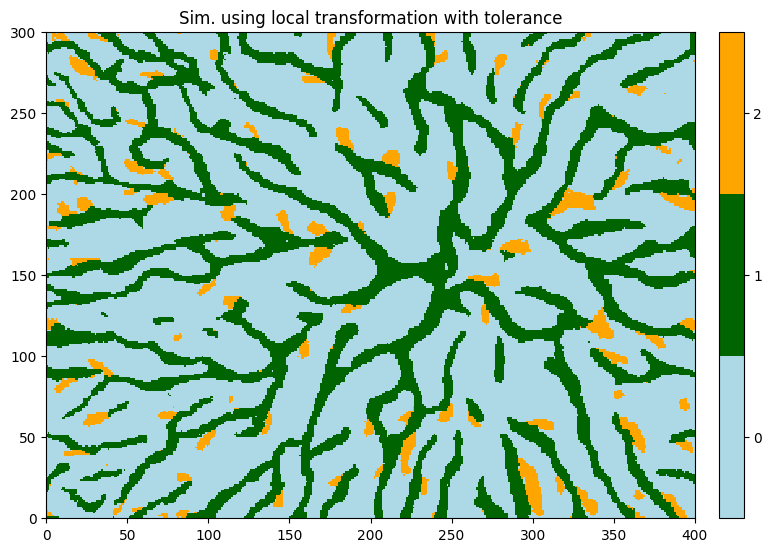

In [15]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(9,9))
gn.imgplot.drawImage2D(sim[0], categ=True, categVal=categ_val, categCol=categ_col,
                       title='Sim. using local transformation with tolerance')
plt.show()

## Remark

Note that, working with local transformation or transformation with tolerance, it can be helpful to limit the size of the search ellipsoid, in order to find similar patterns in the training image during the simulation.